In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix 
from random import sample
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.feature_selection import SequentialFeatureSelector

In [2]:
df1=pd.read_csv(r'C:\Users\kacpr\OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie\Licencjat\Dane\otomoto_offers_eng_23-04-2023.csv',delimiter=';')
#df1=pd.read_csv(r'C:\Users\user\OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie\Licencjat\Dane\otomoto_offers_eng_23-04-2023.csv',delimiter=';')

C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\781195063.py:1: DtypeWarning: Columns (200) have mixed types. Specify dtype option on import or set low_memory=False.
  df1=pd.read_csv(r'C:\Users\kacpr\OneDrive - Akademia Górniczo-Hutnicza im. Stanisława Staszica w Krakowie\Licencjat\Dane\otomoto_offers_eng_23-04-2023.csv',delimiter=';')


# Transformacje

## Wybór zmiennych

In [3]:
df1.shape
df2=df1.copy()
df3= df2.copy()

Te kolumny usuwam, ponieważ są zbędne do naszego modelu: 'id','vat_margin','offer_from','category','offer_creation_date','financing_possibility','offer_title','show_offers_with_vin_number','location','version', 'color','color_type','generation'

wyrzucam offer_creation_year bo wszystkie dane są z tego samego miesiaca i offer_from bo to to samo co seller type tylko po polsku. Category to po prostu osobowe, wiec tą kolumne tez usuwam. Id bo bez sensu

C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\1472644292.py:7: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X=X.fillna(False)
C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\1472644292.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X=X.replace('Tak',True)


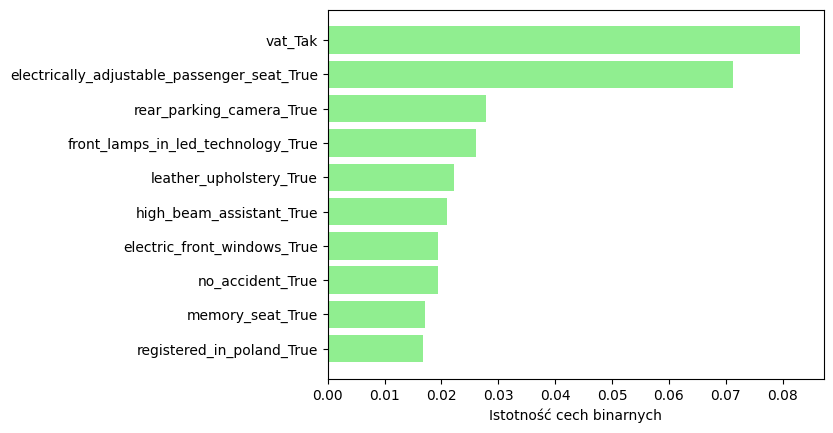

In [4]:
df4=df3.drop(['id','vat_margin','offer_from','category','offer_creation_date','financing_possibility','offer_title','show_offers_with_vin_number','location','version', 'color','color_type','generation'],axis=1).copy()
df3=df3.drop(['id','vat_margin','offer_from','category','offer_creation_date','financing_possibility','offer_title','show_offers_with_vin_number','location','version', 'color','color_type','generation'],axis=1).copy()

#Wybór kolumn od 17-end, czyli wszystkich binarnych
X=df3.iloc[:,17:]
df3=df3.drop(df3.iloc[:,17:],axis=1).copy()
X=X.fillna(False)
X=X.replace('Tak',True)
y=df3['price']

# Usuwanie kolumn, gdzie mniej niż 1% różnorodności (binarne)
from sklearn.feature_selection import VarianceThreshold
selector = VarianceThreshold(threshold=0.01)  
selector.fit(X)
columns_to_remove = X.columns[~selector.get_support()]
X = selector.transform(X)

# Usuwanie kolumn, gdzie mniej niż 1% różnorodności (binarne)
df32 = df4.drop(columns=columns_to_remove, axis=1)
X=df32.iloc[:,17:]
X=X.fillna(0)
X = pd.get_dummies(X, drop_first=True)

# feature selection
import xgboost as xgb
import matplotlib.pyplot as plt

model = xgb.XGBRegressor()
model.fit(X, y)

xgb_importance = model.feature_importances_

sorted_idx = np.argsort(xgb_importance)[-10:]
plt.barh(X.columns[sorted_idx], xgb_importance[sorted_idx], color='lightgreen')
plt.xlabel("Istotność cech binarnych")

top_5_features = X.columns[sorted_idx][-5:]
plt.show()

## lista wybranych kolumn

In [5]:
variables_to_add = ['leather_upholstery', 'front_lamps_in_led_technology', 'rear_parking_camera', 'electrically_adjustable_passenger_seat', 'vat','no_accident','damaged']
df3 = pd.concat([df3, df2[variables_to_add]], axis=1)
df3['vat']=df3['vat'].fillna('Nie')
df3['electrically_adjustable_passenger_seat']=df3['electrically_adjustable_passenger_seat'].fillna(False)
df3['leather_upholstery']=df3['leather_upholstery'].fillna(False)
df3['front_lamps_in_led_technology']=df3['front_lamps_in_led_technology'].fillna(False)
df3['rear_parking_camera']=df3['rear_parking_camera'].fillna(False)
df3['no_accident']=df3['no_accident'].fillna(False)
df3['damaged']=df3['damaged'].fillna(False)

C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\1458003047.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3['electrically_adjustable_passenger_seat']=df3['electrically_adjustable_passenger_seat'].fillna(False)
C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\1458003047.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df3['leather_upholstery']=df3['leather_upholstery'].fillna(False)
C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\1458003047.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will c

### Powiązanie zmiennych binarnych z wiekiem samochodu

In [6]:
pivot_table = pd.pivot_table(df3, values='production_year', index='state', columns='rear_parking_camera', aggfunc='mean')
print(pivot_table)
pivot_table = pd.pivot_table(df3, values='production_year', index='state', columns='vat', aggfunc='mean')
print(pivot_table)
pivot_table = pd.pivot_table(df3, values='production_year', index='state', columns='leather_upholstery', aggfunc='mean')
print(pivot_table)
pivot_table = pd.pivot_table(df3, values='production_year', index='state', columns='front_lamps_in_led_technology', aggfunc='mean')
print(pivot_table)
pivot_table = pd.pivot_table(df3, values='production_year', index='state', columns='electrically_adjustable_passenger_seat', aggfunc='mean')
print(pivot_table)

rear_parking_camera        False        True 
state                                        
New                  2022.609133  2022.582222
Used                 2011.256460  2017.135457
vat            Nie          Tak
state                          
New    2022.581221  2022.595772
Used   2011.473561  2017.898356
leather_upholstery        False        True 
state                                       
New                 2022.610680  2022.525416
Used                2012.578212  2013.815586
front_lamps_in_led_technology        False        True 
state                                                  
New                            2022.593495  2022.593122
Used                           2011.626410  2018.395032
electrically_adjustable_passenger_seat        False        True 
state                                                           
New                                     2022.607693  2022.541182
Used                                    2012.483098  2014.343171


## Czyszczenie i edycja danych

In [7]:
#przewalutowanie na PLN
df3['price'] = df3['price'].astype(float)
df3.loc[df3['currency'] == 'EUR', 'price'] *= 4.29
df3=df3.drop('currency',axis=1)

#Usuniecie samochodów z uszkodzeniami
filt=(df3['no_accident']==True)
df3=df3.loc[filt]
filt=(df3['damaged']=='Tak')
df3=df3.loc[~filt]
len(df3)

#usuniecie miar
df3['mileage'] = df3['mileage'].str.replace(' km','').str.replace(' ','').astype(float)
df3['engine_displacement'] = df3['engine_displacement'].str.replace(' cm3','').str.replace(' ','').astype(float)
df3['power'] = df3['power'].str.replace(' KM','').str.replace(' ','').astype(float)

#kolumna car age
df3['car_age'] = df3['production_year'].apply(lambda x: 2023 - x)
df3=df3.drop('production_year',axis=1)

#kolumna seller experience
df3['seller_experience'] = df3['seller_registration_year'].apply(lambda x: 2023 - x)
df3=df3.drop('seller_registration_year',axis=1)
#kolumna seller experience czyszczenie bledow - serwis OtoMoto powstał w 2004 roku(czyli 19 lat od 2023), a w danych znajduje sie 30 wartości które mają więcej niż 19 lat. Zamienie te wartości na średnią
filt=df3['seller_experience']>19
df3.loc[filt,'seller_experience']=df3['seller_experience'].mean()

C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\295677013.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '10.24230544880593' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df3.loc[filt,'seller_experience']=df3['seller_experience'].mean()


## Podsumowanie czyszczenia i transformacji danych


2. Pozbyłem się potem kolejnych kolumn, które wydawały się zbędnę np. kolor, lokalizacja
3. Zmieniłem wszystkie ceny na jedną walutę
5. Usunąłem pojazdy oznaczone jako 'damaged' albo 'accident'
6. Wyczyściłem zmienne liczbowe z miar 
7. Stworzyłem kolumnę 'car_age'
8. Stworzyłem kolumnę seller_experience

### Sprawdzenie wartości brakujących i odstających

In [8]:
df4=df3.copy()
df4.isnull().values.any()

np.True_

#### Engine_displacement

In [9]:
df4['engine_displacement'].isnull().sum()
filt=(df4['fuel_type']=='Electric') | (df4['fuel_type']=='Hyrdrogen')
df4.loc[filt]

,price,seller_type,vehicle_brand,vehicle_model,mileage,engine_displacement,fuel_type,power,transmission,body_type,...,fuel_consumption_in_city,leather_upholstery,front_lamps_in_led_technology,rear_parking_camera,electrically_adjustable_passenger_seat,vat,no_accident,damaged,car_age,seller_experience
370,307100.0,Authorized Dealer,Skoda,Enyaq,10.0,NaN,Electric,204.0,Automatic,SUV,...,NaN,False,True,True,False,Nie,True,False,0,4.0
614,662900.0,Authorized Dealer,Mercedes-Benz,EQS,5.0,NaN,Electric,360.0,Automatic,SUV,...,NaN,True,False,True,True,Tak,True,False,1,13.0
744,46900.0,Dealer,Renault,Zoe,97000.0,NaN,Electric,88.0,Automatic,Compact,...,NaN,False,False,False,False,Nie,True,False,9,4.0
808,230000.0,Authorized Dealer,Skoda,Enyaq,18906.0,NaN,Electric,204.0,Automatic,SUV,...,NaN,False,True,True,False,Tak,True,False,2,6.0
879,389900.0,Authorized Dealer,Jaguar,I-Pace,17950.0,NaN,Electric,400.0,NaN,SUV,...,NaN,False,True,False,True,Tak,True,False,1,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207889,264900.0,Dealer,Volkswagen,Inny,1.0,NaN,Electric,204.0,Automatic,SUV,...,NaN,False,False,True,False,Tak,True,False,1,3.0
208076,84900.0,Authorized Dealer,Renault,Zoe,36809.0,NaN,Electric,109.0,Automatic,Compact,...,NaN,False,False,True,False,Tak,True,False,5,5.0
208098,390000.0,Authorized Dealer,Mercedes-Benz,EQC,8000.0,NaN,Electric,408.0,Automatic,SUV,...,NaN,False,True,True,True,Tak,True,False,1,15.0
208181,249000.0,Private person,Tesla,Model S,171800.0,NaN,Electric,700.0,Automatic,Sedan,...,NaN,False,False,False,False,Tak,True,False,8,9.0


2636 z 2728 brakujących danych to samochody elektryczne które nie posiadają pojemności silnika, więc zamieniam wartości na 0

In [10]:
df4.loc[filt,'engine_displacement']=0
#resztę samochodów które miały braki uzupełniam średnią z kolumny engine displacement
df4['engine_displacement'].isnull().sum()
df4['engine_displacement'] = df4['engine_displacement'].fillna(df4['engine_displacement'].mean())

#### Number of doors

In [11]:
df4['number_of_doors'].isnull().sum()
#liczba drzwi zostawiam i z racji ze liczba brakow jest mala to usuwam wiersze z brakami
filt = df4['number_of_doors'].isnull()
df4 = df4.loc[~filt]

#### Number of seats

In [12]:
df4['number_of_seats'].isnull().sum()
#jest sporo braków więc tą kolumnę usuwam
df4=df4.drop('number_of_seats',axis=1)

#### Fuel consumption

In [13]:
df4['fuel_consumption_in_city'].isnull().sum()
#niestety tutaj też musze usunąc kolumnę bo ponad połowa to braki
df4=df4.drop('fuel_consumption_in_city',axis=1)

#### Mileage

In [14]:
(df4['mileage'].isnull()).value_counts()

mileage
False    114707
True       1200
Name: count, dtype: int64

In [15]:
df4.loc[(df4['mileage'].isnull())]['state'].value_counts()

state
New    1200
Name: count, dtype: int64

In [16]:
df4.loc[df4['mileage'].isnull(), 'mileage'] = 0
new_data = df4.dropna(axis=0, how='any')
#**W zestawie danych mamy 1200 braków w kolumnie przebieg, ale występują one tylko w przypadku aut nowych. Zakładam że mają zerowy**

#### Reszta braków

In [ ]:
((len(df4)-len(new_data))/len(df4))*100
#Około 0.11 % danych miało jakieś wartości brakujące. Z uwagi na fakt, że jest to bardzo mała liczba to usuwam reszte całych wierszy z danych
df4=new_data.copy()

### Wartosci odstające

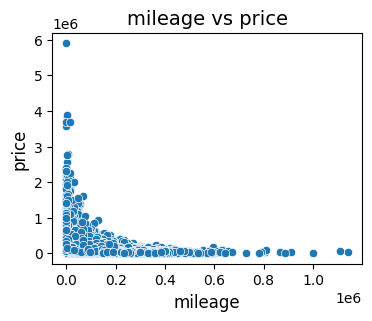

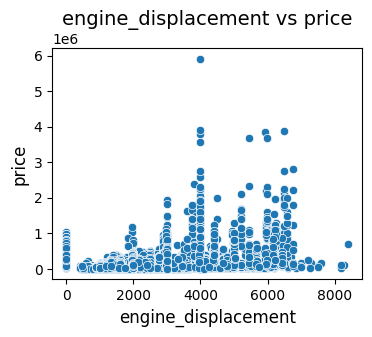

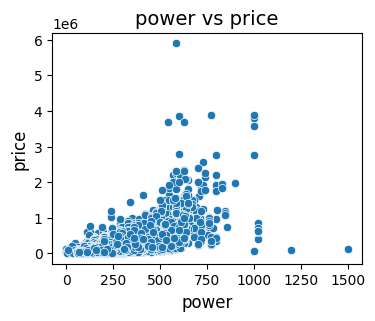

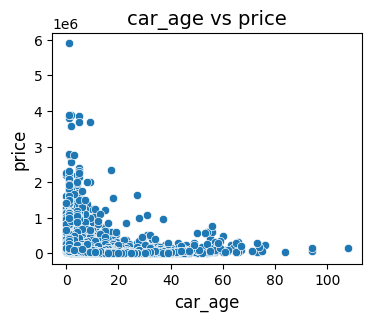

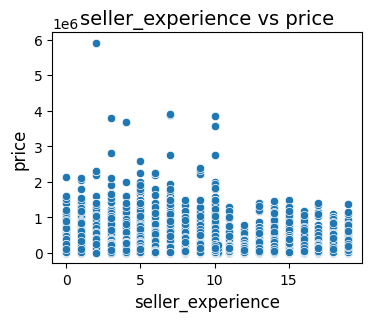

In [18]:
quantitative_vars = ['price', 'mileage', 'engine_displacement', 'power', 'car_age', 'seller_experience']
for var in quantitative_vars[1:]:
    plt.figure(figsize=(4, 3))  
    sns.scatterplot(x=df4[var], y=df4['price'])
    plt.title(f'{var} vs price', fontsize=14)  
    plt.xlabel(var, fontsize=12)  
    plt.ylabel('price', fontsize=12)  
    plt.xticks(fontsize=10) 
    plt.yticks(fontsize=10)
    plt.show()


In [20]:
filt=df4['price']>1500000
df4=df4.loc[~filt]

Pozbywam się aut powyżej 1500000 zł 

In [21]:
filt=df4['power']>800
df4.loc[filt].count()

price                                     20
seller_type                               20
vehicle_brand                             20
vehicle_model                             20
mileage                                   20
engine_displacement                       20
fuel_type                                 20
power                                     20
transmission                              20
body_type                                 20
number_of_doors                           20
state                                     20
leather_upholstery                        20
front_lamps_in_led_technology             20
rear_parking_camera                       20
electrically_adjustable_passenger_seat    20
vat                                       20
no_accident                               20
damaged                                   20
car_age                                   20
seller_experience                         20
dtype: int64

In [22]:
filt=df4['power']>800
df4=df4.loc[~filt]

Usuwam samochody >800 koni

In [25]:
filt=df4['mileage']>1500000
df4=df4.loc[~filt]

Usuwam auta >1500000 km przebiegu

### Wybranie modeli, które mają co najmniej 100 obserwacji

In [26]:
len(df4)

115692

In [27]:
list=df4['vehicle_model'].value_counts()

In [28]:
filtered_models = list[list >= 100].index
df5 = df4[df4['vehicle_model'].isin(filtered_models)]

In [29]:
list[list >= 100].head(10)

vehicle_model
Octavia     2499
Astra       2466
A4          2155
Seria 3     2064
Seria 5     1980
Golf        1976
Focus       1906
Passat      1840
A6          1779
Insignia    1522
Name: count, dtype: int64

In [30]:
list[list >= 100].tail(20)

vehicle_model
Eclipse Cross        110
Leaf                 110
Captiva              109
Elantra              109
C5X                  108
EQS                  108
9.mar                108
C3 Picasso           107
Jogger               106
Jimny                106
V90 Cross Country    104
CX-30                103
Niro                 101
Tiguan Allspace      100
i10                  100
Ranger               100
Cooper S             100
Q2                   100
Altea XL             100
Modus                100
Name: count, dtype: int64

Poniżej odkyrwam, że dwa modele Ferrari nie zostały usunięte ponieważ model o nazwie Californai również produkował Volksvagen, dlatego nie zostały usuniete te dwa przypadki

In [31]:
ferrari_data = df5[df5['vehicle_brand'] == 'Ferrari']
ferrari_data

,price,seller_type,vehicle_brand,vehicle_model,mileage,engine_displacement,fuel_type,power,transmission,body_type,...,state,leather_upholstery,front_lamps_in_led_technology,rear_parking_camera,electrically_adjustable_passenger_seat,vat,no_accident,damaged,car_age,seller_experience
53663,646000.0,Authorized Dealer,Ferrari,California,68289.0,4297.0,Gasoline,460.0,Automatic,Cabriolet,...,Used,False,False,True,True,Nie,True,False,9,10.0
83835,750000.0,Private person,Ferrari,California,14950.0,3855.0,Gasoline,560.0,Automatic,Cabriolet,...,Used,True,False,True,True,Nie,True,False,7,9.0


In [32]:
df5 = df5[df5['vehicle_brand'] != 'Ferrari']

Usuwam wszystkie modele oznaczone jako 'inny'

In [33]:
df5 = df5[df5['vehicle_model'] != 'Inny']


In [34]:
ferrari_data = df5[df5['vehicle_brand'] == 'Ferrari']
ferrari_data

,price,seller_type,vehicle_brand,vehicle_model,mileage,engine_displacement,fuel_type,power,transmission,body_type,...,state,leather_upholstery,front_lamps_in_led_technology,rear_parking_camera,electrically_adjustable_passenger_seat,vat,no_accident,damaged,car_age,seller_experience


Zmiana na kategoryczne zmienne

In [36]:
categorical_columns = ['seller_type', 'fuel_type','vehicle_model','vehicle_brand', 'transmission', 'body_type','number_of_doors','state','leather_upholstery',
       'front_lamps_in_led_technology', 'rear_parking_camera',
       'electrically_adjustable_passenger_seat', 'vat']
numeric_features = ['price','power', 'mileage', 'car_age','engine_displacement','seller_experience']
df5[categorical_columns] = df5[categorical_columns].astype('category')
df5.drop(columns=['damaged'], inplace=True)
df5.drop(columns=['no_accident'], inplace=True)
df5[numeric_features]=df5[numeric_features].astype(np.float32)

# EDA i korelacje

usuniecie dwoch fiatow 500 ponad 60 letnich

In [37]:
df5=df5[df5['car_age']<60]

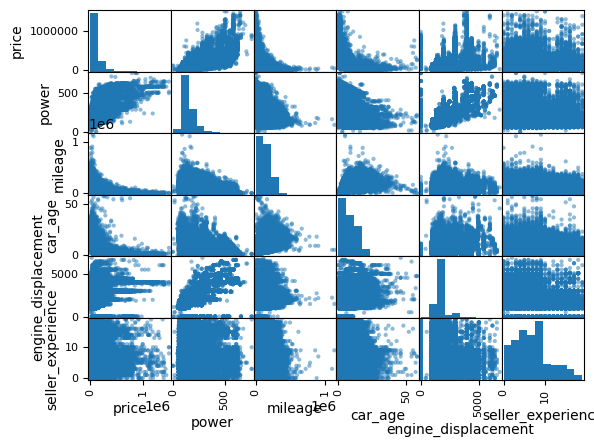

In [38]:
scatter_matrix(df5[numeric_features]) #sns.pairplot(df4[['price','mileage','engine_displacement','power','car_age','seller_experience']], diag_kind='kde')
plt.show()

## Czy cena zależy od marki auta?

C:\Users\kacpr\AppData\Local\Temp\ipykernel_7780\2483847591.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  top_10_brands = df5.groupby('vehicle_brand')['price'].mean().nlargest(10).index


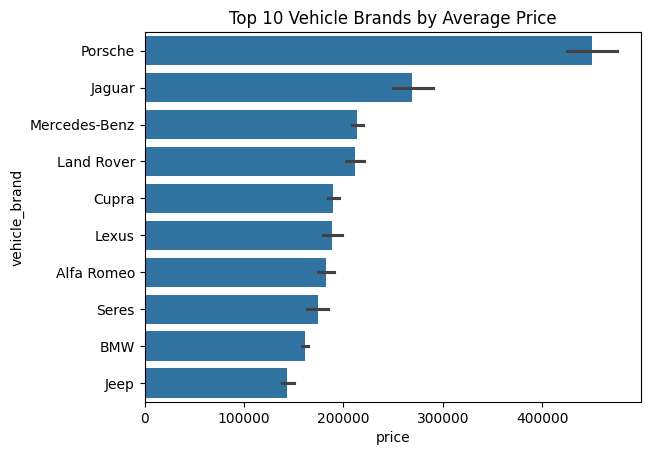

In [ ]:
top_10_brands = df5.groupby('vehicle_brand')['price'].mean().nlargest(10).index
filtered_df = df5[df5['vehicle_brand'].isin(top_10_brands)]

plt.figure()
sns.barplot(x=filtered_df['price'], y=filtered_df['vehicle_brand'], orient='h', order=top_10_brands)
plt.title('Top 10 marek samochodów według średniej ceny')
plt.show()

vehicle_brand
BMW              9599
Volkswagen       9095
Audi             8380
Opel             7633
Ford             7555
Skoda            6798
Mercedes-Benz    6303
Renault          4981
Toyota           4368
Hyundai          4009
Name: count, dtype: int64


<Axes: ylabel='vehicle_brand'>

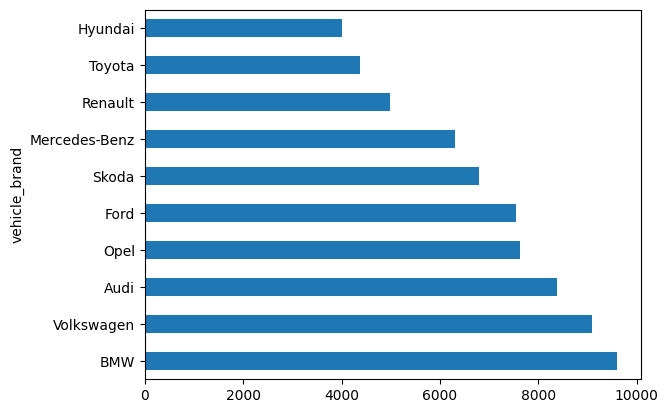

In [41]:
most_popular_brands = df5['vehicle_brand'].value_counts().nlargest(10)
print(most_popular_brands)

most_popular_brands.plot(kind='barh')


vehicle_model
Octavia     2499
Astra       2466
A4          2155
Seria 3     2064
Seria 5     1980
Golf        1976
Focus       1906
Passat      1840
A6          1779
Insignia    1522
Name: count, dtype: int64


<Axes: ylabel='vehicle_model'>

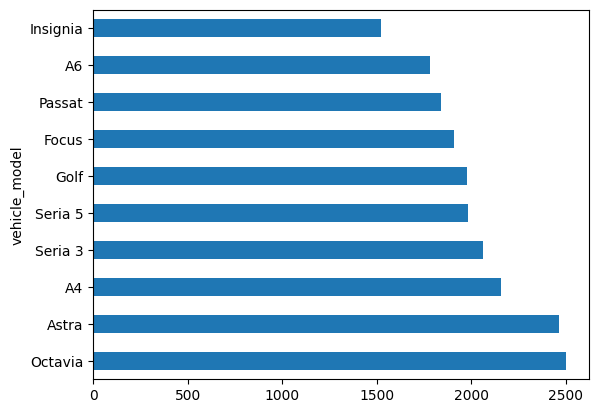

In [42]:
most_popular_brands = df5['vehicle_model'].value_counts().nlargest(10)
print(most_popular_brands)

most_popular_brands.plot(kind='barh')

## Typ paliwa

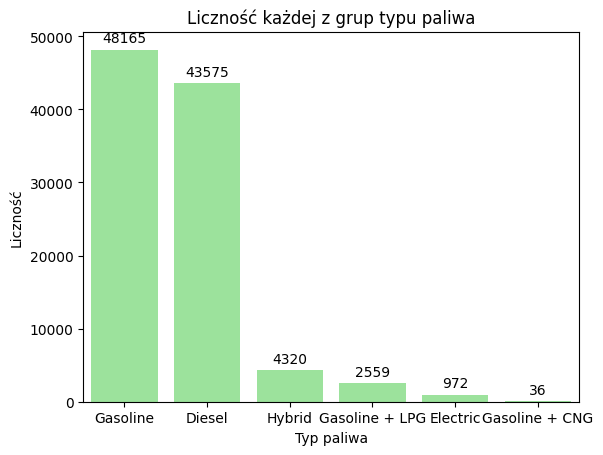

In [43]:
plt.figure()
ax = sns.countplot(x=df5['fuel_type'], order=df5['fuel_type'].value_counts().index,color='lightgreen')
plt.title('Liczność każdej z grup typu paliwa')
plt.xlabel('Typ paliwa')
plt.ylabel('Liczność')

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), 
                textcoords='offset points')

plt.show()

#usuniecie CNG
filt=(df5['fuel_type']=='Gasoline + CNG')
df5=df5.loc[~filt]

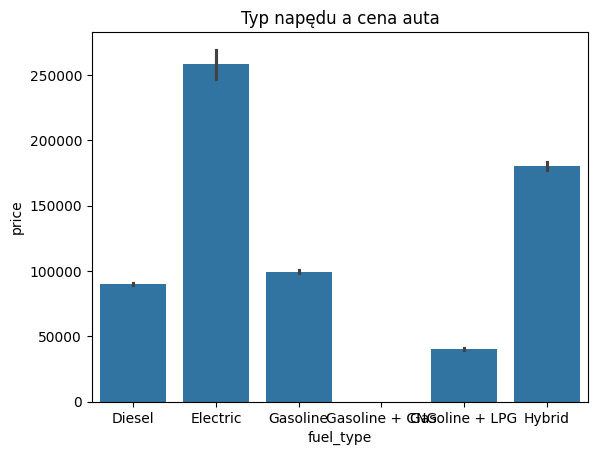

In [45]:
plt.figure()
sns.barplot(x=df5['fuel_type'],y=df5['price'])
plt.title('Typ napędu a cena auta')
plt.show()

## Macierze korelacji

Index(['price', 'power', 'car_age', 'mileage', 'transmission_Manual',
       'vat_Tak', 'state_Used', 'engine_displacement',
       'rear_parking_camera_True', 'front_lamps_in_led_technology_True',
       'electrically_adjustable_passenger_seat_True',
       'leather_upholstery_True', 'seller_type_Private person',
       'vehicle_brand_Mercedes-Benz', 'vehicle_brand_Porsche'],
      dtype='object')


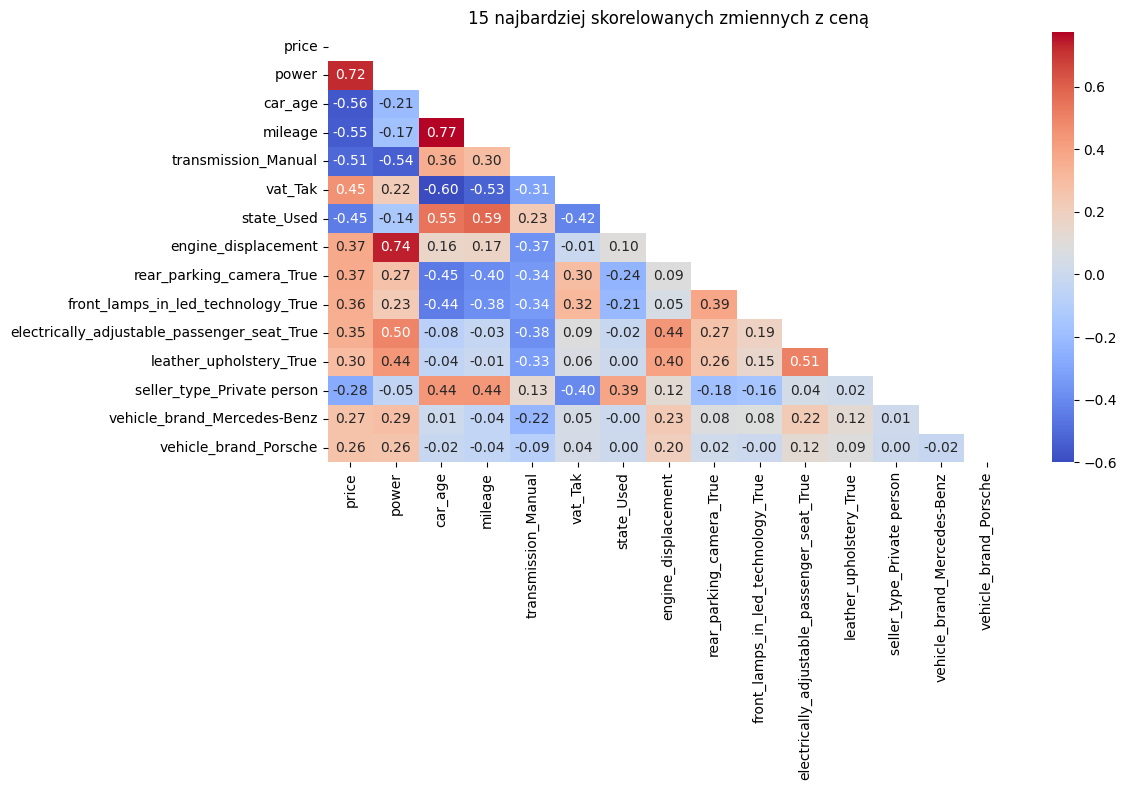

In [46]:
import seaborn as sns


df_encoded = pd.get_dummies(df5.drop(columns=['vehicle_model']), drop_first=True)

correlations = df_encoded.corr()['price'].abs().sort_values(ascending=False)

top_15_features = correlations.index[0:15]  


import matplotlib.pyplot as plt

print(top_15_features)


plt.figure(figsize=(12, 8))
mask = np.triu(np.ones_like(df_encoded[top_15_features].corr(), dtype=bool)) 
sns.heatmap(df_encoded[top_15_features].corr(), mask=mask, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("15 najbardziej skorelowanych zmiennych z ceną")
plt.tight_layout()
plt.show()

### Wykresy po czyszczeniu danych

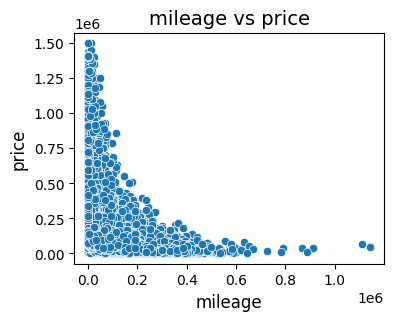

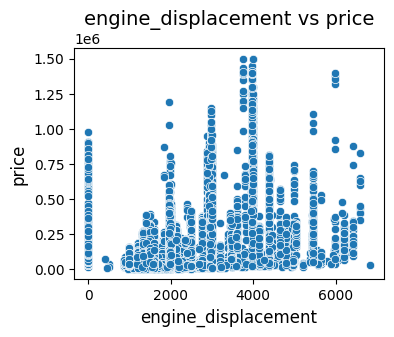

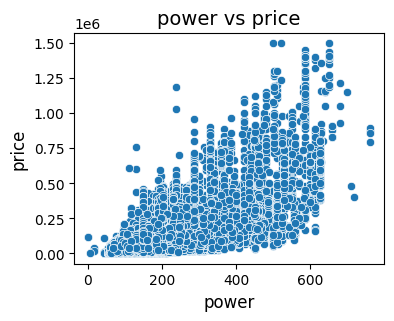

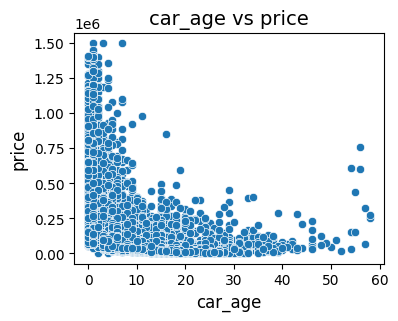

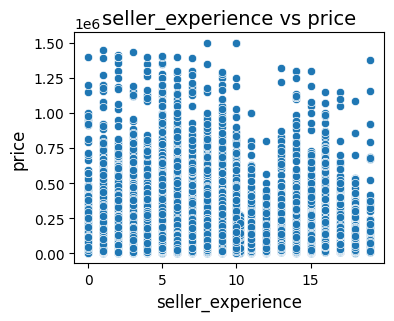

In [47]:
quantitative_vars = ['price', 'mileage', 'engine_displacement', 'power', 'car_age', 'seller_experience']
for var in quantitative_vars[1:]:
    plt.figure(figsize=(4, 3))  
    sns.scatterplot(x=df5[var], y=df5['price'])
    plt.title(f'{var} vs price', fontsize=14)  
    plt.xlabel(var, fontsize=12)  
    plt.ylabel('price', fontsize=12)  
    plt.xticks(fontsize=10) 
    plt.yticks(fontsize=10)
    plt.show()

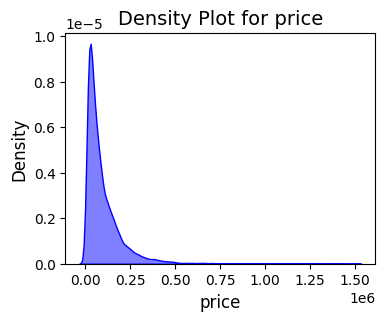

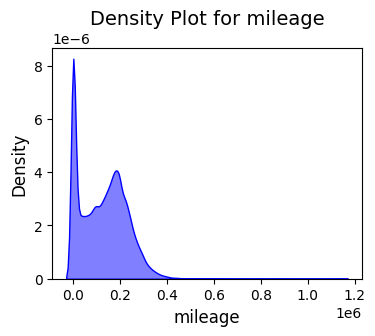

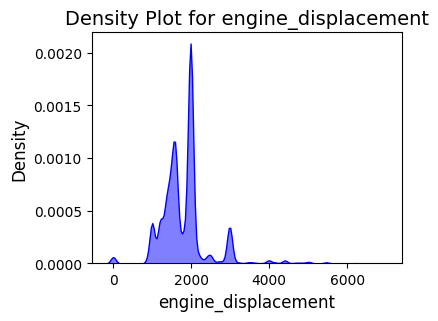

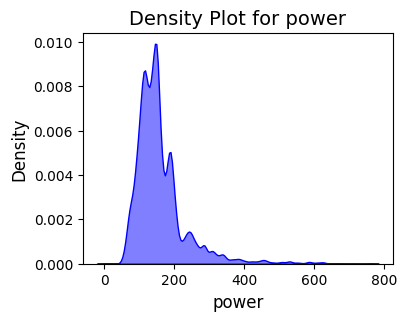

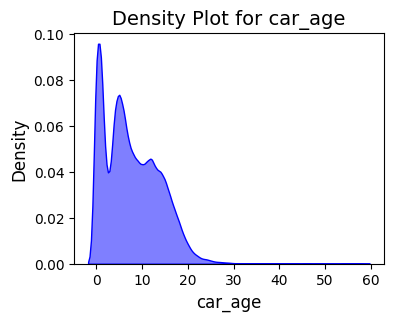

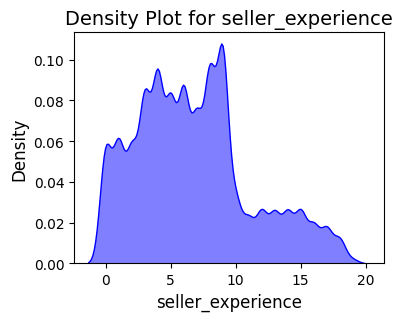

In [48]:
for var in quantitative_vars:
    plt.figure(figsize=(4, 3))
    sns.kdeplot(df5[var], fill=True, color="blue", alpha=0.5)
    plt.title(f'Density Plot for {var}', fontsize=14)
    plt.xlabel(var, fontsize=12)
    plt.ylabel('Density', fontsize=12)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.show()


In [51]:
df5.to_csv('dane_po_transformacji.csv')

# Skalowanie cech numerycznych

In [52]:
df5=df5.drop('vehicle_brand',axis=1)
df4_log=df5.copy()
df4_log['price']=np.log(df4_log['price'])

df4_sqrt=df5.copy()
df4_sqrt['price']=np.sqrt(df4_sqrt['price'])

Z racji, że nasze zmienne są w różnej skali to przeskaluje je poprzez standard scaler (x-u)/s

In [53]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
numeric_features = ['power', 'mileage', 'car_age','engine_displacement','seller_experience']
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_features = ['seller_type', 'fuel_type','vehicle_model', 'transmission', 'body_type','number_of_doors','state','leather_upholstery',
       'front_lamps_in_led_technology', 'rear_parking_camera',
       'electrically_adjustable_passenger_seat', 'vat']
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


y = df5['price']
X = df5.drop('price', axis=1)
X_preprocessed = preprocessor.fit_transform(X)
y_log = df4_log['price']
X_log = df4_log.drop('price', axis=1)
X_log_preprocessed = preprocessor.fit_transform(X_log)

y_sqrt = df4_sqrt['price']
X_sqrt = df4_sqrt.drop('price', axis=1)
X_sqrt_preprocessed = preprocessor.fit_transform(X_sqrt)


**Podział na testowy i uczący zbiór**

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2,
                                                    random_state=0,shuffle=True)

X_log_train, X_log_test, y_log_train, y_log_test = train_test_split(X_log_preprocessed, y_log, test_size=0.2,
                                                    random_state=0,shuffle=True)

X_sqrt_train, X_sqrt_test, y_sqrt_train, y_sqrt_test = train_test_split(X_sqrt_preprocessed, y_sqrt, test_size=0.2,
                                                    random_state=0,shuffle=True)

# Regresja liniowa

In [55]:
from sklearn.linear_model import LinearRegression
regresja = LinearRegression()
regresja.fit(X_train, y_train)

y_pred_Reg=regresja.predict(X_test)
MAPE_Reg=mean_absolute_percentage_error(y_pred_Reg,y_test)
MAE_Reg=mean_absolute_error(y_pred_Reg,y_test)


#### Logarytm regresja

In [56]:
regresja.fit(X_log_train, y_log_train)
y_pred_Reg_log=regresja.predict(X_log_test)
MAPE_Reg_log=mean_absolute_percentage_error(np.exp(y_pred_Reg_log),np.exp(y_log_test))
MAE_Reg_log=mean_absolute_error(np.exp(y_pred_Reg_log),np.exp(y_log_test))

Pierwiastek regresja

In [58]:
regresja.fit(X_sqrt_train, y_sqrt_train)
y_pred_Reg_sqrt=regresja.predict(X_sqrt_test)
MAPE_Reg_sqrt=mean_absolute_percentage_error(np.square(y_pred_Reg_sqrt),np.square(y_sqrt_test))
MAE_Reg_sqrt=mean_absolute_error(np.square(y_pred_Reg_sqrt),np.square(y_sqrt_test))

# Ridge

In [59]:
from sklearn.linear_model import Ridge
param_grid = {
    'alpha': [0.1, 1, 10, 100]  
}


clf = GridSearchCV(estimator=Ridge(), param_grid=param_grid,scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)
clf.fit(X_train, y_train)
best_params_Ridge = clf.best_params_
alpha1 = best_params_Ridge.get('alpha', None)

ridge=Ridge(alpha=alpha1)
ridge.fit(X_train, y_train)
y_pred_Ridge=ridge.predict(X_test)
MAPE_Ridge=mean_absolute_percentage_error(y_pred_Ridge,y_test)
MAE_Ridge=mean_absolute_error(y_pred_Ridge,y_test)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ........................alpha=0.1;, score=-0.566 total time=   0.4s
[CV 2/5] END ........................alpha=0.1;, score=-0.547 total time=   0.5s
[CV 3/5] END ........................alpha=0.1;, score=-0.554 total time=   0.4s
[CV 4/5] END ........................alpha=0.1;, score=-0.562 total time=   0.3s
[CV 5/5] END ........................alpha=0.1;, score=-0.542 total time=   0.3s
[CV 1/5] END ..........................alpha=1;, score=-0.567 total time=   0.3s
[CV 2/5] END ..........................alpha=1;, score=-0.547 total time=   0.4s
[CV 3/5] END ..........................alpha=1;, score=-0.554 total time=   0.4s
[CV 4/5] END ..........................alpha=1;, score=-0.562 total time=   0.4s
[CV 5/5] END ..........................alpha=1;, score=-0.543 total time=   0.4s
[CV 1/5] END .........................alpha=10;, score=-0.570 total time=   0.3s
[CV 2/5] END .........................alpha=10;, 

## Ridge logarytm

In [60]:
param_grid = {
    'alpha': [0.001,0.1, 1, 10, 100]  
}

clf = GridSearchCV(estimator=Ridge(), param_grid=param_grid,scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)
clf.fit(X_log_train, y_log_train)
best_params_Ridge_log = clf.best_params_
alpha1 = best_params_Ridge_log.get('alpha', None)

ridge=Ridge(alpha=alpha1)
ridge.fit(X_log_train, y_log_train)
y_pred_Ridge_log=ridge.predict(X_log_test)
MAPE_Ridge_log=mean_absolute_percentage_error(np.exp(y_pred_Ridge_log),np.exp(y_log_test))
MAE_Ridge_log=mean_absolute_error(np.exp(y_pred_Ridge_log),np.exp(y_log_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.001;, score=-0.013 total time=   0.4s
[CV 2/5] END ......................alpha=0.001;, score=-0.013 total time=   0.4s
[CV 3/5] END ......................alpha=0.001;, score=-0.013 total time=   0.3s
[CV 4/5] END ......................alpha=0.001;, score=-0.013 total time=   0.3s
[CV 5/5] END ......................alpha=0.001;, score=-0.013 total time=   0.3s
[CV 1/5] END ........................alpha=0.1;, score=-0.013 total time=   0.3s
[CV 2/5] END ........................alpha=0.1;, score=-0.013 total time=   0.3s
[CV 3/5] END ........................alpha=0.1;, score=-0.013 total time=   0.3s
[CV 4/5] END ........................alpha=0.1;, score=-0.013 total time=   0.3s
[CV 5/5] END ........................alpha=0.1;, score=-0.013 total time=   0.3s
[CV 1/5] END ..........................alpha=1;, score=-0.013 total time=   0.3s
[CV 2/5] END ..........................alpha=1;, 

Pierwiastek Ridge

In [61]:
param_grid = {
    'alpha': [0.001, 0.1, 1, 10, 100]
}

clf = GridSearchCV(estimator=Ridge(), param_grid=param_grid, scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)
clf.fit(X_sqrt_train, y_sqrt_train)
best_params_Ridge_sqrt = clf.best_params_
alpha1 = best_params_Ridge_sqrt.get('alpha', None)

ridge = Ridge(alpha=alpha1)
ridge.fit(X_sqrt_train, y_sqrt_train)
y_pred_Ridge_sqrt = ridge.predict(X_sqrt_test)
MAPE_Ridge_sqrt = mean_absolute_percentage_error(np.square(y_pred_Ridge_sqrt), np.square(y_sqrt_test))
MAE_Ridge_sqrt = mean_absolute_error(np.square(y_pred_Ridge_sqrt), np.square(y_sqrt_test))

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ......................alpha=0.001;, score=-0.097 total time=   0.5s
[CV 2/5] END ......................alpha=0.001;, score=-0.095 total time=   0.3s
[CV 3/5] END ......................alpha=0.001;, score=-0.095 total time=   0.3s
[CV 4/5] END ......................alpha=0.001;, score=-0.096 total time=   0.3s
[CV 5/5] END ......................alpha=0.001;, score=-0.096 total time=   0.3s
[CV 1/5] END ........................alpha=0.1;, score=-0.097 total time=   0.3s
[CV 2/5] END ........................alpha=0.1;, score=-0.095 total time=   0.3s
[CV 3/5] END ........................alpha=0.1;, score=-0.095 total time=   0.3s
[CV 4/5] END ........................alpha=0.1;, score=-0.096 total time=   0.3s
[CV 5/5] END ........................alpha=0.1;, score=-0.096 total time=   0.4s
[CV 1/5] END ..........................alpha=1;, score=-0.097 total time=   0.3s
[CV 2/5] END ..........................alpha=1;, 

# Lasy losowe

In [ ]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None],
    'min_samples_split': [2, 5, 9],
    'max_features': [10,25,50, 70],
    'min_samples_leaf': [5, 15, 20]
}



clf = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1), param_grid=param_grid, 
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)

clf.fit(X_train, y_train)

best_params_Forest = clf.best_params_
max_features1 = best_params_Forest.get('max_features', None)
min_samples_split1 = best_params_Forest.get('min_samples_split', None)
min_samples_leaf1 = best_params_Forest.get('min_samples_leaf', None)
n_estimators1 = best_params_Forest.get('n_estimators', None)
Forest=RandomForestRegressor(n_jobs=-1,max_features=max_features1,min_samples_split=min_samples_split1,min_samples_leaf=min_samples_leaf1,n_estimators=n_estimators1)
Forest.fit(X_train, y_train)
y_pred_Las=Forest.predict(X_test)
MAE_las=mean_absolute_error(y_test,y_pred_Las)
MAPE_las=mean_absolute_percentage_error(y_test,y_pred_Las)


Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.155 total time=  18.0s
[CV 2/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.150 total time=  17.9s
[CV 3/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.152 total time=  22.0s
[CV 4/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.159 total time=  22.5s
[CV 5/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.154 total time=  21.7s
[CV 1/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-0.153 total time=  43.8s
[CV 2/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-0.

KeyboardInterrupt: 

## Z logarytmem

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None],
    'min_samples_split': [2, 5, 9],
    'max_features': [10,25,50, 70],
    'min_samples_leaf': [5, 15, 20]
}


clf = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1), param_grid=param_grid, 
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)

clf.fit(X_log_train, y_log_train)

best_params_Forest_log = clf.best_params_
max_features1 = best_params_Forest_log.get('max_features', None)
min_samples_split1 = best_params_Forest_log.get('min_samples_split', None)
min_samples_leaf1 = best_params_Forest_log.get('min_samples_leaf', None)
n_estimators1 = best_params_Forest_log.get('n_estimators', None)
Forest=RandomForestRegressor(n_jobs=-1,max_features=max_features1,min_samples_split=min_samples_split1,min_samples_leaf=min_samples_leaf1,n_estimators=n_estimators1)
Forest.fit(X_log_train, y_log_train)
y_pred_Las_log=Forest.predict(X_log_test)
MAPE_las_log=mean_absolute_percentage_error(np.exp(y_log_test),np.exp(y_pred_Las_log))
MAE_las_log=mean_absolute_error(np.exp(y_log_test),np.exp(y_pred_Las_log))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
[CV 1/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.012 total time=  27.8s
[CV 2/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.012 total time=  27.3s
[CV 3/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.012 total time=  27.7s
[CV 4/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.013 total time=  27.6s
[CV 5/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=50;, score=-0.013 total time=  27.5s
[CV 1/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-0.012 total time=  54.0s
[CV 2/5] END max_depth=None, max_features=50, min_samples_leaf=5, min_samples_split=2, n_estimators=100;, score=-0.

### Z pierwiastkiem

In [ ]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None],
    'min_samples_split': [2, 5, 9],
    'max_features': [10,25,50, 70],
    'min_samples_leaf': [5, 15, 20]
}

clf = GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1), param_grid=param_grid,
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)

clf.fit(X_sqrt_train, y_sqrt_train)

best_params_Forest_sqrt = clf.best_params_
max_features1 = best_params_Forest_sqrt.get('max_features', None)
min_samples_split1 = best_params_Forest_sqrt.get('min_samples_split', None)
min_samples_leaf1 = best_params_Forest_sqrt.get('min_samples_leaf', None)
n_estimators1 = best_params_Forest_sqrt.get('n_estimators', None)

Forest = RandomForestRegressor(
    n_jobs=-1,
    max_features=max_features1,
    min_samples_split=min_samples_split1,
    min_samples_leaf=min_samples_leaf1,
    n_estimators=n_estimators1
)
Forest.fit(X_sqrt_train, y_sqrt_train)
y_pred_Las_sqrt = Forest.predict(X_sqrt_test)
MAPE_las_sqrt = mean_absolute_percentage_error(np.square(y_sqrt_test), np.square(y_pred_Las_sqrt))
MAE_las_sqrt = mean_absolute_error(np.square(y_sqrt_test), np.square(y_pred_Las_sqrt))

# MLP

In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (64, 64),
        (128, 64), (64, 32, 16), (32, 16)
    ],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': ['auto']
}


clf = RandomizedSearchCV(estimator=MLPRegressor(), param_distributions=param_grid,
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5,n_iter=20,n_jobs=-1)

clf.fit(X_train, y_train)

best_params_MLP = clf.best_params_
hidden_layer_sizes1 = best_params_MLP.get('hidden_layer_sizes', None)
activation1 = best_params_MLP.get('activation', None)
learning_rate1 = best_params_MLP.get('learning_rate', None)
batch_size1 = best_params_MLP.get('batch_size', None)
Network=MLPRegressor(hidden_layer_sizes=hidden_layer_sizes1,activation=activation1,learning_rate=learning_rate1,batch_size=batch_size1)
Network.fit(X_train, y_train)
y_pred_MLP=Network.predict(X_test)
MAE_MLP=mean_absolute_error(y_test,y_pred_MLP)
MAPE_MLP=mean_absolute_percentage_error(y_test,y_pred_MLP)


Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.899 total time= 3.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.897 total time= 3.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.900 total time= 3.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.898 total time= 3.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.895 total time= 3.7min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.899 total time= 3.7min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.897 total time= 3.7min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.900 total time= 3.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.898 total time= 3.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.895 total time= 3.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.899 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.897 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.900 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.898 total time= 5.0min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.895 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.899 total time= 5.1min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.897 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.900 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.898 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.895 total time= 4.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.128 total time= 3.5min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.127 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.124 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.126 total time= 3.4min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.127 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.122 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.129 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.123 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.125 total time= 3.4min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.125 total time= 3.3min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.115 total time= 4.7min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.117 total time= 4.6min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.113 total time= 4.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.113 total time= 5.9min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=constant;, score=-0.116 total time= 5.2min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.111 total time= 5.1min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.117 total time= 4.4min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.113 total time= 4.8min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.114 total time= 5.2min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END activation=relu, batch_size=auto, hidden_layer_sizes=(64, 64, 64), learning_rate=adaptive;, score=-0.113 total time= 4.6min


c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


### z logarytmem

In [ ]:
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (64, 64),
        (128, 64), (64, 32, 16), (32, 16)
    ],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': ['auto']
}


clf = RandomizedSearchCV(estimator=MLPRegressor(), param_distributions=param_grid,
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5,n_iter=20,n_jobs=-1)

clf.fit(X_log_train, y_log_train)

best_params_MLP_log = clf.best_params_
hidden_layer_sizes1 = best_params_MLP_log.get('hidden_layer_sizes', None)
activation1 = best_params_MLP_log.get('activation', None)
learning_rate1 = best_params_MLP_log.get('learning_rate', None)
batch_size1 = best_params_MLP_log.get('batch_size', None)
Network=MLPRegressor(hidden_layer_sizes=hidden_layer_sizes1,activation=activation1,learning_rate=learning_rate1,batch_size=batch_size1)
Network.fit(X_log_train, y_log_train)
y_pred_MLP_log=Network.predict(X_log_test)
MAE_MLP_log=mean_absolute_error(np.exp(y_log_test),np.exp(y_pred_MLP_log))
MAPE_MLP_log=mean_absolute_percentage_error(np.exp(y_log_test),np.exp(y_pred_MLP_log))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.010 total time=  57.4s
[CV 2/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.010 total time= 1.4min
[CV 3/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.010 total time= 1.3min
[CV 4/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.010 total time= 1.2min
[CV 5/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=constant;, score=-0.009 total time= 1.3min
[CV 1/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.010 total time= 1.3min
[CV 2/5] END activation=tanh, batch_size=auto, hidden_layer_sizes=(64, 64), learning_rate=adaptive;, score=-0.010 total time= 1.2min
[CV 3/5] 

## Z pierwiastkiem

In [ ]:
param_grid = {
    'hidden_layer_sizes': [
        (50,), (100,), (100, 50), (64, 64),
        (128, 64), (64, 32, 16), (32, 16)
    ],
    'activation': ['tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'learning_rate_init': [0.001, 0.01],
    'batch_size': ['auto']
}


clf = RandomizedSearchCV(estimator=MLPRegressor(), param_distributions=param_grid,
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5,n_iter=20,n_jobs=-1)

clf.fit(X_sqrt_train, y_sqrt_train)

best_params_MLP_sqrt = clf.best_params_
hidden_layer_sizes1 = best_params_MLP_sqrt.get('hidden_layer_sizes', None)
activation1 = best_params_MLP_sqrt.get('activation', None)
learning_rate1 = best_params_MLP_sqrt.get('learning_rate', None)
batch_size1 = best_params_MLP_sqrt.get('batch_size', None)
Network = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes1, activation=activation1, learning_rate=learning_rate1, batch_size=batch_size1)
Network.fit(X_sqrt_train, y_sqrt_train)
y_pred_MLP_sqrt = Network.predict(X_sqrt_test)
MAE_MLP_sqrt = mean_absolute_error(np.square(y_sqrt_test), np.square(y_pred_MLP_sqrt))
MAPE_MLP_sqrt = mean_absolute_percentage_error(np.square(y_sqrt_test), np.square(y_pred_MLP_sqrt))

# XGBOOST

In [ ]:
import xgboost as xgb
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'min_child_weight': [1, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}



clf = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, 
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)

clf.fit(X_train, y_train)

best_params_XGB = clf.best_params_
n_estimators1 = best_params_XGB.get('n_estimators', None)
learning_rate1 = best_params_XGB.get('learning_rate', None)
max_depth1 = best_params_XGB.get('max_depth', None)
xgb_model=xgb.XGBRegressor(objective='reg:linear',n_estimators=n_estimators1,learning_rate=learning_rate1,max_depth=max_depth1)
xgb_model.fit(X_train, y_train)
y_pred_XGB=xgb_model.predict(X_test)
MAE_XGB=mean_absolute_error(y_test,y_pred_XGB)
MAPE_XGB=mean_absolute_percentage_error(y_test,y_pred_XGB)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-1.678 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-1.720 total time=   0.2s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-1.646 total time=   0.2s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-1.693 total time=   0.2s
[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=50;, score=-1.775 total time=   0.2s
[CV 1/5] END learning_rate=0.001, max_depth=1, n_estimators=100;, score=-1.648 total time=   0.3s
[CV 2/5] END learning_rate=0.001, max_depth=1, n_estimators=100;, score=-1.689 total time=   0.3s
[CV 3/5] END learning_rate=0.001, max_depth=1, n_estimators=100;, score=-1.616 total time=   0.3s
[CV 4/5] END learning_rate=0.001, max_depth=1, n_estimators=100;, score=-1.662 total time=   0.3s
[CV 5/5] END learning_rate=0.001, max_depth=1, n_estimators=1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:43:38] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


### Z logarytmem

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'min_child_weight': [1, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}


clf = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, 
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)

clf.fit(X_log_train, y_log_train)

best_params_XGB_log = clf.best_params_
n_estimators1 = best_params_XGB_log.get('n_estimators', None)
learning_rate1 = best_params_XGB_log.get('learning_rate', None)
max_depth1 = best_params_XGB_log.get('max_depth', None)
xgb_model=xgb.XGBRegressor(objective='reg:linear',n_estimators=n_estimators1,learning_rate=learning_rate1,max_depth=max_depth1)
xgb_model.fit(X_log_train, y_log_train)
y_pred_XGB_log=xgb_model.predict(X_log_test)
MAPE_XGB_log=mean_absolute_percentage_error(np.exp(y_log_test),np.exp(y_pred_XGB_log))
MAE_XGB_log=mean_absolute_error(np.exp(y_log_test),np.exp(y_pred_XGB_log))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.068 total time=   0.5s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.069 total time=   1.3s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.068 total time=   0.7s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.069 total time=   0.4s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=50;, score=-0.070 total time=   0.3s
[CV 1/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.066 total time=   0.5s
[CV 2/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.067 total time=   0.5s
[CV 3/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.066 total time=   0.5s
[CV 4/5] END learning_rate=0.001, max_depth=2, n_estimators=100;, score=-0.067 total time=   0.5s
[CV 5/5] END learning_rate=0.001, max_depth=2, n_estimators=1

c:\Users\user\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:50:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)


## Z pierwiastkiem

In [ ]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7,9],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1],
    'min_child_weight': [1, 5],
    'reg_alpha': [0, 0.1],
    'reg_lambda': [1, 5]
}

clf = GridSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror'), param_grid=param_grid, 
                   scoring='neg_mean_absolute_percentage_error', verbose=3, cv=5)

clf.fit(X_sqrt_train, y_sqrt_train)

best_params_XGB_sqrt = clf.best_params_
n_estimators1 = best_params_XGB_sqrt.get('n_estimators', None)
learning_rate1 = best_params_XGB_sqrt.get('learning_rate', None)
max_depth1 = best_params_XGB_sqrt.get('max_depth', None)
xgb_model = xgb.XGBRegressor(objective='reg:linear', n_estimators=n_estimators1, learning_rate=learning_rate1, max_depth=max_depth1)
xgb_model.fit(X_sqrt_train, y_sqrt_train)
y_pred_XGB_sqrt = xgb_model.predict(X_sqrt_test)
MAPE_XGB_sqrt = mean_absolute_percentage_error(np.square(y_sqrt_test), np.square(y_pred_XGB_sqrt))
MAE_XGB_sqrt = mean_absolute_error(np.square(y_sqrt_test), np.square(y_pred_XGB_sqrt))

# Tabela wyników

In [ ]:
import pandas as pd

comparison_table = pd.DataFrame({
    'Actual': np.exp(y_log_test),
    'MLPLog': np.exp(y_pred_MLP_log),
    'MLP': y_pred_MLP,
    'LogLinear': np.exp(y_pred_Reg_log),
    'RidgeLog': np.exp(y_pred_Ridge_log),
    'laslosLog': np.exp(y_pred_Las_log),
    'xgboostLog': np.exp(y_pred_XGB_log),
    'Linear': y_pred_Reg,
    'Ridge': y_pred_Ridge,
    'laslos': y_pred_Las,
    'xgboost': y_pred_XGB,
    'MLPSqrt': np.square(y_pred_MLP_sqrt),
    'LinearSqrt': np.square(y_pred_Reg_sqrt),
    'RidgeSqrt': np.square(y_pred_Ridge_sqrt),
    'laslosSqrt': np.square(y_pred_Las_sqrt),
    'xgboostSqrt': np.square(y_pred_XGB_sqrt),
})


comparison_table.tail(20)

,Actual,MLPLog,MLP,LogLinear,RidgeLog,laslosLog,xgboostLog,Linear,Ridge,laslos,xgboost
13529,209000.015625,170090.757204,185614.210816,173069.724737,172751.962348,158411.999353,165513.250000,249276.256242,249342.154254,171748.444025,182269.265625
10311,69999.031250,70517.279957,69657.344946,67745.386836,67476.756254,69437.767196,73113.062500,68469.760649,68432.221317,72220.978535,79139.695312
106350,10999.005859,9577.460650,10808.004143,11221.214551,11227.535583,12487.121464,11202.568359,-20327.654909,-20286.826639,13338.691667,12925.791016
36583,171700.000000,160829.156088,162363.848407,142629.102051,141868.927933,156954.678137,154740.218750,153872.084778,153725.122181,170657.121995,133187.546875
54649,201899.953125,184023.211862,194529.733504,170338.122175,170470.553455,175858.137911,184359.046875,185652.612873,185698.294428,178327.516508,175378.484375
43367,51799.996094,46989.833306,47338.447931,40380.692864,40232.204709,39916.644985,46833.160156,35650.303934,35569.218950,40683.115217,42067.527344
123269,99000.015625,90663.112883,129774.092605,102793.509260,103190.363868,88892.939611,103322.695312,81304.724833,81211.733140,98935.818928,91882.820312
53415,31900.001953,32624.021316,31407.525216,29228.555783,29365.971413,29842.572369,31699.060547,42474.593012,42643.878369,31826.466862,27875.457031
154151,195100.031250,194621.799079,185365.335751,158915.886509,158647.161156,186433.597169,186796.562500,191140.246650,191166.326508,194298.128266,180381.859375
161132,56600.023438,54671.227175,48732.365217,59752.897799,59768.960191,53775.531177,53085.828125,40566.637710,40478.973569,55826.923888,61100.281250


In [ ]:
errors_table = pd.DataFrame({
    'MLPLog': {'MAPE': MAPE_MLP_log, 'MAE': MAE_MLP_log},
    'MLP': {'MAPE': MAPE_MLP, 'MAE': MAE_MLP},
    'MLPSqrt': {'MAPE': MAPE_MLP_sqrt, 'MAE': MAE_MLP_sqrt},
    'LogLinear': {'MAPE': MAPE_Reg_log, 'MAE': MAE_Reg_log},
    'Linear': {'MAPE': MAPE_Reg, 'MAE': MAE_Reg},
    'LinearSqrt': {'MAPE': MAPE_Reg_sqrt, 'MAE': MAE_Reg_sqrt},
    'RidgeLog': {'MAPE': MAPE_Ridge_log, 'MAE': MAE_Ridge_log},
    'Ridge': {'MAPE': MAPE_Ridge, 'MAE': MAE_Ridge},
    'RidgeSqrt': {'MAPE': MAPE_Ridge_sqrt, 'MAE': MAE_Ridge_sqrt},
    'laslosLog': {'MAPE': MAPE_las_log, 'MAE': MAE_las_log},
    'laslos': {'MAPE': MAPE_las, 'MAE': MAE_las},
    'laslosSqrt': {'MAPE': MAPE_las_sqrt, 'MAE': MAE_las_sqrt},
    'xgboostLog': {'MAPE': MAPE_XGB_log, 'MAE': MAE_XGB_log},
    'xgboost': {'MAPE': MAPE_XGB, 'MAE': MAE_XGB},
    'xgboostSqrt': {'MAPE': MAPE_XGB_sqrt, 'MAE': MAE_XGB_sqrt}
})

errors_table.to_csv('errors_table.csv')
errors_table

,MLPLog,MLP,LogLinear,Linear,RidgeLog,Ridge,laslosLog,laslos,xgboostLog,xgboost
MAPE,0.107076,0.108641,0.221277,1.471525,0.222070,1.631730,0.151530,0.179171,0.105110,0.169753
MAE,8981.776184,8742.718989,13676.684510,25569.375658,13646.667942,25571.932275,13674.536891,13041.280159,8844.400391,12706.487305


In [ ]:
import pandas as pd


params_dict = {
    'Ridge': best_params_Ridge,
    'Ridge_log': best_params_Ridge_log,
    'Ridge_sqrt': best_params_Ridge_sqrt,
    'MLP': best_params_MLP,
    'MLP_log': best_params_MLP_log,
    'MLP_sqrt': best_params_MLP_sqrt,
    'XGB': best_params_XGB,
    'XGB_log': best_params_XGB_log,
    'XGB_sqrt': best_params_XGB_sqrt,
    'Forest': best_params_Forest,
    'Forest_log': best_params_Forest_log,
    'Forest_sqrt': best_params_Forest_sqrt
}

params_df = pd.DataFrame(params_dict).T
params_df

({'alpha': 0.1},
 {'alpha': 1},
 {'activation': 'relu',
  'batch_size': 'auto',
  'hidden_layer_sizes': (64, 64, 64),
  'learning_rate': 'adaptive'},
 {'activation': 'tanh',
  'batch_size': 'auto',
  'hidden_layer_sizes': (64, 64),
  'learning_rate': 'constant'},
 {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200},
 {'learning_rate': 0.3, 'max_depth': 9, 'n_estimators': 200},
 {'max_depth': None,
  'max_features': 30,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 100},
 {'max_depth': None,
  'max_features': 30,
  'min_samples_leaf': 5,
  'min_samples_split': 2,
  'n_estimators': 200})